# Loads the models and evaluates them within different groups

In [1]:
from _load_llm_results import *
sns.set_theme(
    context='paper',
    style='whitegrid',
    font_scale=1
)
import numpy as np
import warnings
import os
import importlib
import sys; sys.path.append('../')
from evaluate_model import read_data
from sklearn.metrics import average_precision_score, roc_auc_score
from sklearn.metrics import balanced_accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

from tqdm import tqdm
from glob import glob

## Loading the models

In [2]:
def load_model(*, method, target, scale, expert_features, rich_prompt, 
                  repeat, fold, random_state):
    
    folder = f"{results_path}/{target}/{method}/"
    file = '_'.join([targets[target], method, str(scale), str(expert_features),
                     str(rich_prompt), str(repeat), fold, str(random_state)])

    try:
        cp_df = pd.read_json(f"{folder}{file}.json", typ="series")
    except Exception as e:
        print("Bad results in file", f"{folder}{file}.json")
        raise e

    # unifying column name
    cp_df = cp_df.rename(index={"few_feature": "icd_only"})
        
    # Evaluating the program in the other folds
    cp_file = file.replace(targets[target], target) + '_program'

    # removing the fold from filename if not an iterative method
    if 'iterative' not in file: 
        cp_file = cp_file.replace(f"_{fold}_", '__')

    try:
        cp_module = importlib.__import__(
            (folder[3:]+cp_file).replace('/', '.'), # skip '../' from the begging of the string
            globals(),
            locals(),
            ["predict_hyptertension"],
        )
        cp_function = cp_module.predict_hypertension
    except Exception as e:
        print("Could not find program in file", folder[3:]+cp_file.replace('/', '.'))
        raise e

    return cp_df, cp_function

In [3]:
cp_df, cp_function = load_model(
    method = 'GPT_4o_iterative_Classifier',
    target = 'res_htn_dx_ia',
    scale = False,
    expert_features = True,
    rich_prompt = True,
    repeat = 1,
    fold = 'C',
    random_state = '14724'
)

## Evaluating on subgroups

In [4]:
def eval(cp_function, metric, X, y):
    try:
        prob = np.array(cp_function(X))
    except Exception:
        prob = np.zeros(shape=len(X))
    try:
        if metric in [average_precision_score, roc_auc_score]:
            return metric(y, prob)
        else:
            return metric(y, np.where(prob> 0.5, 1, 0))
    except ValueError:
        return np.nan
    

def evaluate_subgroups(cp_function, cp_df, bootstrap=False, n_reps=1_000,
                       subgroup=None,
                       repeat=None, fold=None, random_state=None):
    
    # If repeat, fold, and random_state is not specified, then it loads
    # the dataset with information from cp_df (the same used to train the model)
    if repeat is None or fold is None or random_state is None:
        repeat, fold, random_state = cp_df['RunID'], cp_df['fold'], cp_df['random_state']

    X_train, y_train, X_test, y_test = read_data(
        targets_rev[cp_df['target']],
        fold,
        repeat,
        cp_df['scale'],
        False, # set icd_only to false so it loads all data
        data_dir,
        random_state
    )
    
    if subgroup is not None:
        X_train = X_train.query(subgroup)
        X_test  = X_test.query(subgroup)

        y_train = y_train.loc[X_train.index]
        y_test  = y_test.loc[X_test.index]

    # display(X_test.head(10))
    # print(X_test.index)
    # display(y_test)

    res = []
    for metric in [balanced_accuracy_score, average_precision_score, roc_auc_score]:
        entry = f"{metric.__name__}_test_{repeat}_{fold}"
        if bootstrap:
            for i in tqdm(range(n_reps)):
                samples = np.random.randint(0,len(y_test)-1, size=len(y_test))
                d = {
                    'metric' : entry,
                    'value' : eval(cp_function, metric, X_test.iloc[samples, :], y_test.iloc[samples]),
                    'sample_size' : len(y_test),
                }
                if subgroup is not None:
                    d['query'] = subgroup
                    d['male'], d['ethnicity'] = subgroup.split(' & ')

                res.append(d)
        else: # Only one repetition with the entire test data, without sampling
            d = {
                'metric' : entry,
                'value' : eval(cp_function, metric, X_test, y_test),
                'sample_size' : len(y_test),
            }
            if subgroup is not None:
                d['query'] = subgroup
                d['male'], d['ethnicity'] = subgroup.split(' & ')
            res.append(d)

    return res

In [5]:
res = evaluate_subgroups(cp_function, cp_df, bootstrap=False, n_reps=1_000,
                         repeat=101, fold='A', random_state=cp_df['random_state'])

res

[{'metric': 'balanced_accuracy_score_test_101_A',
  'value': 0.8622593687767788,
  'sample_size': 300},
 {'metric': 'average_precision_score_test_101_A',
  'value': 0.7252323834719637,
  'sample_size': 300},
 {'metric': 'roc_auc_score_test_101_A',
  'value': 0.9224850642689035,
  'sample_size': 300}]

In [6]:
table_data = []
for query in [
    "(`Male` == 1) & (`BLACK` == 1)",
    "(`Male` == 1) & (`WHITE` == 1)",
    "(`Male` == 1) & (`OTHER` == 1)",
    
    "(`Male` == 0) & (`BLACK` == 1)",
    "(`Male` == 0) & (`WHITE` == 1)",
    "(`Male` == 0) & (`OTHER` == 1)",
]:
    res = evaluate_subgroups(cp_function, cp_df, bootstrap=True, n_reps=1_000,
                             subgroup=query, repeat=101, fold='A', random_state=cp_df['random_state'])
    table_data += res

100%|██████████| 1000/1000 [00:01<00:00, 525.37it/s]


In [7]:
df_subgroups = pd.DataFrame(table_data)
display(df_subgroups)

,metric,value,sample_size,query,male,ethnicity
0,balanced_accuracy_score_test_101_A,0.741259,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
1,balanced_accuracy_score_test_101_A,0.734472,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
2,balanced_accuracy_score_test_101_A,0.727941,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
3,balanced_accuracy_score_test_101_A,0.738782,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
4,balanced_accuracy_score_test_101_A,0.820370,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
...,...,...,...,...,...,...
17995,roc_auc_score_test_101_A,1.000000,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)
17996,roc_auc_score_test_101_A,NaN,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)
17997,roc_auc_score_test_101_A,1.000000,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)
17998,roc_auc_score_test_101_A,1.000000,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)


In [32]:
table = df_subgroups.replace({'..._test_101_A' : ''}, regex=True)\
        .groupby(['ethnicity', 'male', 'metric'])['value'].mean()\
        .reset_index().pivot(index=['ethnicity', 'male'], columns=['metric']).droplevel(0, 1)

display(table)

latex_table = table.to_latex(
    index=True,
    column_format="lrrr",
    escape=False
)

print(latex_table)

# Save LaTeX table to file
filename = f"{paper_dir}/tab_best_model_subgroups.tex"
with open(filename, 'w') as f:
    f.write(latex_table)

print(f"\nLaTeX table saved to {filename}\n")

metric                        average_precision_sc  balanced_accuracy_sc  \
ethnicity      male                                                        
(`BLACK` == 1) (`Male` == 0)              0.826690              0.854628   
               (`Male` == 1)              0.658255              0.736919   
(`OTHER` == 1) (`Male` == 0)              0.627000              1.000000   
               (`Male` == 1)              0.327349              0.848200   
(`WHITE` == 1) (`Male` == 0)              0.666817              0.857629   
               (`Male` == 1)              0.742447              0.929326   

metric                        roc_auc_sc  
ethnicity      male                       
(`BLACK` == 1) (`Male` == 0)    0.938318  
               (`Male` == 1)    0.852438  
(`OTHER` == 1) (`Male` == 0)    1.000000  
               (`Male` == 1)    0.888871  
(`WHITE` == 1) (`Male` == 0)    0.883195  
               (`Male` == 1)    0.932660

\begin{tabular}{lrrr}
\toprule
 & metric & average_precision_sc & balanced_accuracy_sc & roc_auc_sc \\
ethnicity & male &  &  &  \\
\midrule
\multirow[t]{2}{*}{(`BLACK` == 1)} & (`Male` == 0) & 0.826690 & 0.854628 & 0.938318 \\
 & (`Male` == 1) & 0.658255 & 0.736919 & 0.852438 \\
\cline{1-5}
\multirow[t]{2}{*}{(`OTHER` == 1)} & (`Male` == 0) & 0.627000 & 1.000000 & 1.000000 \\
 & (`Male` == 1) & 0.327349 & 0.848200 & 0.888871 \\
\cline{1-5}
\multirow[t]{2}{*}{(`WHITE` == 1)} & (`Male` == 0) & 0.666817 & 0.857629 & 0.883195 \\
 & (`Male` == 1) & 0.742447 & 0.929326 & 0.932660 \\
\cline{1-5}
\bottomrule
\end{tabular}


LaTeX table saved to ../paper/tab_best_model_subgroups.tex



,metric,value,sample_size,query,male,ethnicity
0,balanced_accuracy_score_test_101_A,0.741259,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
1,balanced_accuracy_score_test_101_A,0.734472,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
2,balanced_accuracy_score_test_101_A,0.727941,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
3,balanced_accuracy_score_test_101_A,0.738782,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
4,balanced_accuracy_score_test_101_A,0.820370,37,(`Male` == 1) & (`BLACK` == 1),(`Male` == 1),(`BLACK` == 1)
...,...,...,...,...,...,...
17995,roc_auc_score_test_101_A,1.000000,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)
17996,roc_auc_score_test_101_A,NaN,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)
17997,roc_auc_score_test_101_A,1.000000,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)
17998,roc_auc_score_test_101_A,1.000000,16,(`Male` == 0) & (`OTHER` == 1),(`Male` == 0),(`OTHER` == 1)


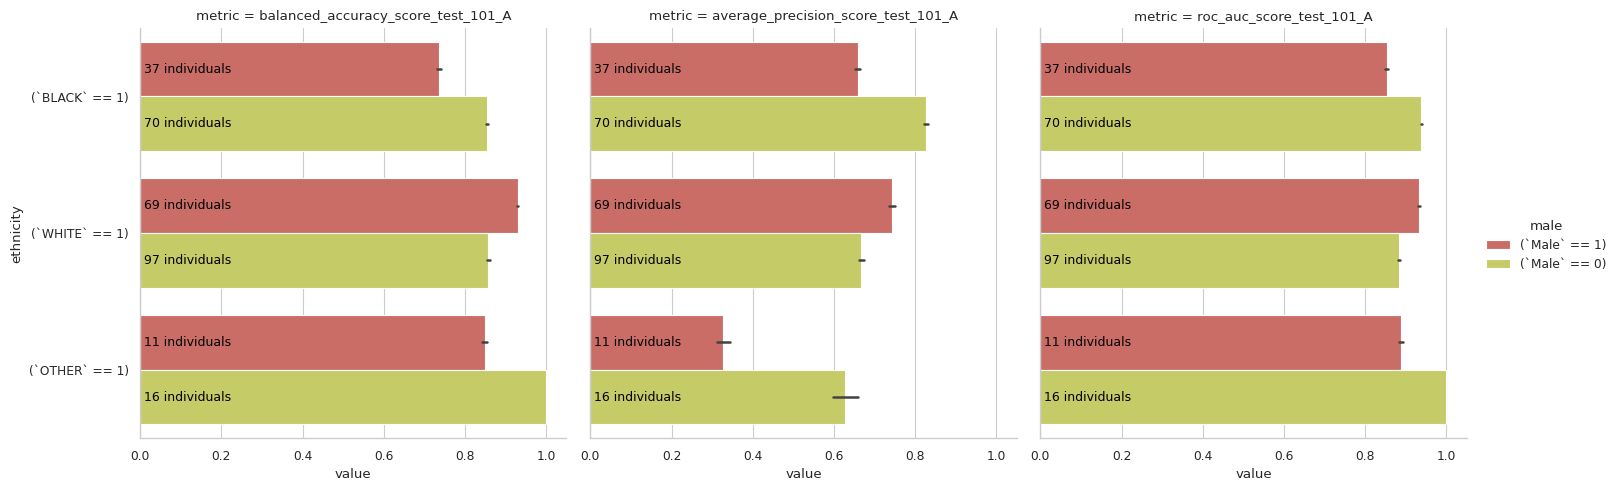

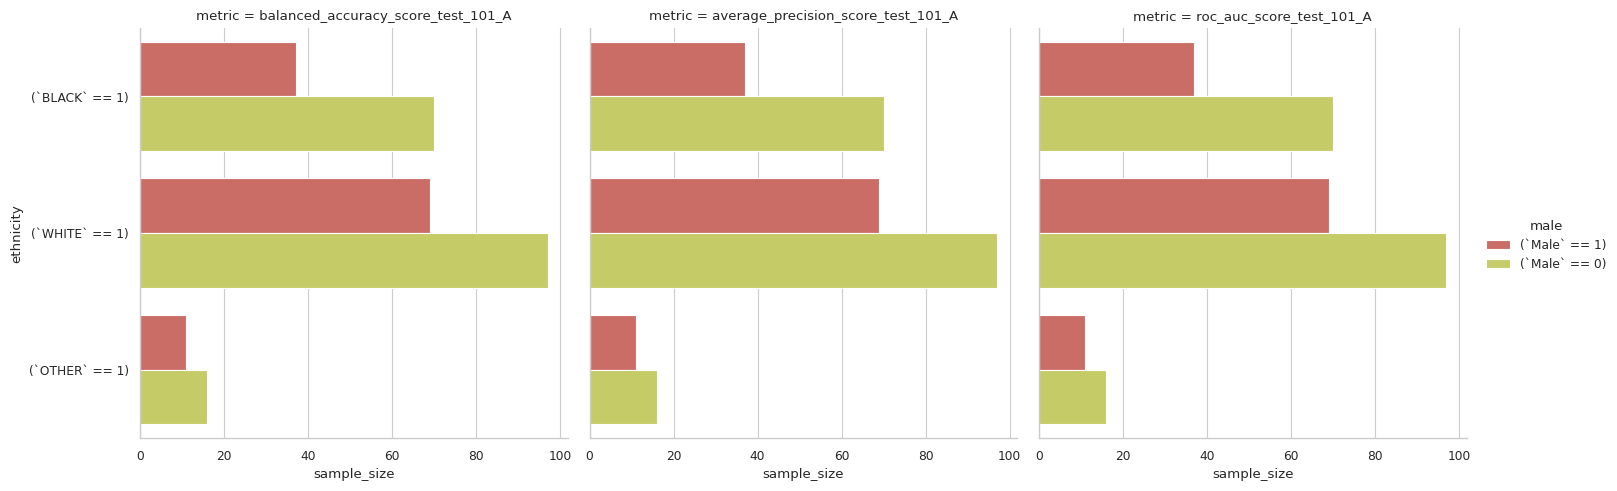

In [8]:
palette = sns.color_palette("hls", 6) # ['#374aa3', '#cc6666', '#6688d0', '#ffcccc', '#336699', '#99ccff']

g = sns.catplot(df_subgroups, palette=palette,
            y='ethnicity', x='value', hue='male', col='metric', kind='bar')

# same plot but for size so we get this values in the same schema
g_size = sns.catplot(df_subgroups, palette=palette,
            y='ethnicity', x='sample_size', hue='male', col='metric', kind='bar')

# Iterate over the FacetGrid axes to write the sample size on top of each bar
for ax, ax_size in zip(g.axes.flat, g_size.axes.flat):
    for container, container_size in zip(ax.containers, ax_size.containers):  # Iterate over bar containers
        for bar, bar_size in zip(container, container_size):
            ax.text(0.01, # bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f'{int(bar_size.get_width())} individuals',
                    ha='left', va='center', fontsize=9, color='black')

In [ ]:
def predict_aTRH(*features):
  if high_BP_during_htn_meds_3>=2
  or high_BP_during_htn_meds_4_plus>=2:
    prob = 0.9
  if mean_systolic < 135
  and mean_diastolic < 80:
    prob -= 0.3
  if low_K_N > 0:
    prob -= 0.2
  if high_BP_during_htn_meds_4_plus>5:
    prob += 0.1
  else:
    prob = 0.1
  if high_BP_during_htn_meds_2 >= 5
  or mean_systolic >= 140:
    prob += 0.4
  if high_BP_during_htn_meds_3>=1:
    prob += 0.2
  if low_K_N == 0
  and high_BP_during_htn_meds_4_plus>=1:
    prob += 0.3
  return prob